**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [ ]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [ ]:
# splitting in train, test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# linear regression with L2 penalty
class LinearRegression:
    def __init__(self, c=0.0):
        self.c = c
        self.w = None
        self.ws = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        self.w = np.linalg.inv(X.T.dot(X) + self.c * np.eye(n_features + 1)).dot(X.T).dot(y)
        self.ws.append(self.w)


    def predict(self, X):
        n_samples, _ = X.shape
        X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        return X.dot(self.w)

class StandardScaler:
    """
    custom implementation of standard scaler for feature scaling.
    """
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

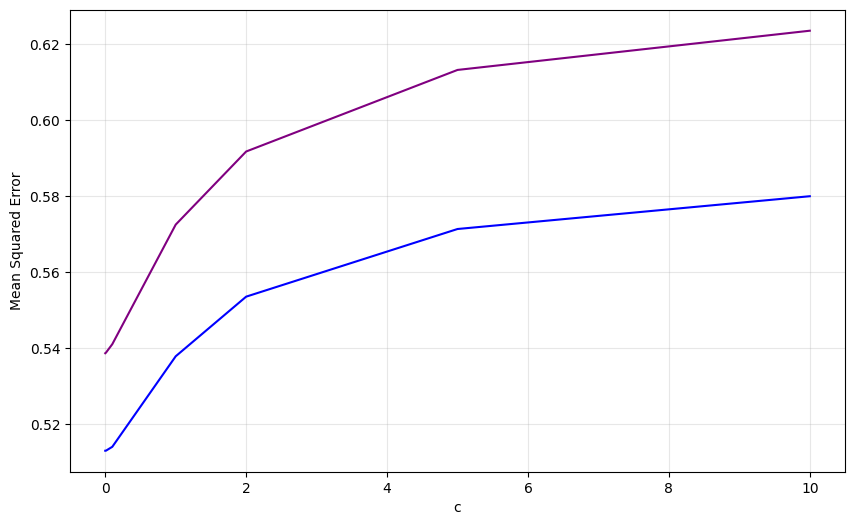


Melhor valor de c: 0.0000
MSE de validação mínimo: 0.5386

Performance no conjunto de teste:
MSE de teste: 0.5559


In [ ]:
# Seu código aqui
c_values = [0, 0.01, 0.1, 1, 2, 5, 10]

train_mse = []
val_mse = []

# Testa diferentes valores de c
for c in c_values:
    #fit
    model = LinearRegression(c=c)
    model.fit(X_train, y_train)

    #pred
    y_pred_test = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # compute mse
    train_mse.append(np.mean((y_pred_test - y_train) ** 2))
    val_mse.append(np.mean((y_pred_val - y_val) ** 2))

# plot
plt.figure(figsize=(10, 6))
plt.plot(c_values, train_mse, label='MSE Treino', color='blue')
plt.plot(c_values, val_mse, label='MSE Validação', color='purple')
plt.xlabel('c')
plt.ylabel('Mean Squared Error')
plt.grid(True, alpha=0.3)
plt.show()

# melhor c
best_idx = np.argmin(val_mse)
best_c = c_values[best_idx]

print(f"\nMelhor valor de c: {best_c:.4f}")
print(f"MSE de validação mínimo: {val_mse[best_idx]:.4f}")

# agrupa
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# avalia no conjunto de teste
final_model = LinearRegression(c=best_c)
final_model.fit(X_train_val, y_train_val)

y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"\nPerformance no conjunto de teste:")
print(f"MSE de teste: {test_mse:.4f}")

### Comentário:

Observe que, conforme aumentamos o parâmetro de regularização c, o erro quadrático médio (MSE) também aumenta, indicando que não utilizar a regularização (isto é, c = 0) é a melhor escolha — tanto nos dados de treino quanto de validação.

No conjunto de teste, o erro também se mantém baixo quando c = 0, reforçando que, de fato, não aplicar regularização é uma boa escolha neste caso. Isso pode ser justificado pelo fato de estarmos lidando com um banco de dados muito grande, onde não há ganho significativo em termos de redução de variância. Assim, a aplicação de regularização apenas aumenta o viés do modelo sem trazer benefícios claros. Além disso, podemos supor que os pesos "reais" do modelo tendem a ser maiores, e a regularização estaria enviesando os coeficientes para valores menores, o que compromete a capacidade do modelo de representar adequadamente os dados.

---

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*.

In [ ]:
# Seu código aqui
def _create_folds(n_samples, n_splits, random_state):
    """Cria e embaralha os índices para os folds."""
    np.random.seed(random_state)
    indices = np.random.permutation(n_samples)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    return folds

def _folds(X, y, all_folds, fold_idx):
    """Separa os dados em treino e teste para um fold específico."""
    test_indices = all_folds[fold_idx]
    train_indices = np.concatenate([all_folds[i] for i in range(len(all_folds)) if i != fold_idx])

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

#--------------------- Normal
class CrossValidation:
    """
    grid search for the best hyperparameters.
    """
    def __init__(self, model, param_grid, scale = False, cv=5, random_state=42):
        self.model = model
        self.param_grid = param_grid
        self.cv = cv
        self.random_state = random_state
        self.results_ = []
        self.best_params_ = None
        self.best_score_ = float('inf')
        self.scale = scale

    def _create_param_combinations(self):
        """
        create all combinations of hyperparameters to be tested.
        """
        keys = list(self.param_grid.keys())
        values = list(self.param_grid.values())
        combinations = []

        def create_combinations(current_combination, index):
            """
            recursively create combinations of hyperparameters.
            needed because the combinations are stored in a dict.
            """
            if index == len(keys):
                combinations.append(dict(current_combination))
                return
            key = keys[index]
            for value in values[index]:
                current_combination[key] = value
                create_combinations(current_combination, index + 1)

        create_combinations({}, 0)
        return combinations

    def fit(self, X, y):
        """
        Executa a validação cruzada para encontrar os melhores hiperparâmetros
        para o modelo fornecido, usando os dados X e y.
        """
        folds = _create_folds(X.shape[0], self.cv, self.random_state)

        #generate all combinations of hyperparameters
        param_combinations = list(self._create_param_combinations())

        for params in param_combinations:
            fold_scores = []
            for i in range(self.cv):
                X_train, X_val, y_train, y_val = _folds(X, y, folds, i)

                if self.scale:
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train = scaler.transform(X_train)
                    X_val = scaler.transform(X_val)

                #train
                model = self.model(**params)
                model.fit(X_train, y_train)

                #predict
                preds = model.predict(X_val)

                #scores
                mse = mean_squared_error(y_val, preds)
                fold_scores.append(mse)

            mean_score = np.mean(fold_scores)
            self.results_.append({'params': params, 'mean_mse': mean_score})

            if mean_score < self.best_score_:
                self.best_score_ = mean_score
                self.best_params_ = params

        return self

#--------------------- Nested

class NestedCrossValidation:
    """
    Implementa Nested Cross-Validation para seleção de modelo e hiperparâmetros.
    """

    def __init__(self, model, param_grid, outer_cv=5, inner_cv=3, scale = False, random_state=42):
        self.model = model
        self.param_grid = param_grid
        self.outer_cv = outer_cv
        self.inner_cv = inner_cv
        self.results_ = []
        self.mean_score_ = None
        self.std_score_ = None
        self.random_state = random_state
        self.scale = scale


    def fit(self, X, y):
        """
        perform grid search to find the best hyperparameters.
        """
        # create folds test-train/val
        outer_folds = _create_folds(X.shape[0], self.outer_cv, self.random_state)
        outer_scores = []

        #outer
        for i in range(len(outer_folds)):
            print(f"Processando fold externo {i+1}/{self.outer_cv}...")

            X_train_val, X_test, y_train_val, y_test = _folds(X, y, outer_folds, i)

            if self.scale:
                scaler = StandardScaler()
                scaler.fit(X_train)
                X_train_val = scaler.transform(X_train_val)
                X_test = scaler.transform(X_test)

            # inner
            inner_cv_runner = CrossValidation(
                model=self.model,
                param_grid=self.param_grid,
                scale=self.scale,
                cv=self.inner_cv,
                random_state=self.random_state
            )

            inner_cv_runner.fit(X_train_val, y_train_val)
            best_params_for_fold = inner_cv_runner.best_params_

            # outer evaluation
            final_model = self.model(**best_params_for_fold)
            final_model.fit(X_train_val, y_train_val)

            preds = final_model.predict(X_test)
            outer_score = mean_squared_error(y_test, preds)
            outer_scores.append(outer_score)

            self.results_.append({
                'fold': i+1,
                'chosen_params': best_params_for_fold,
                'outer_mse': outer_score,
                'inner_results': inner_cv_runner
            })

        # performance final
        self.mean_score_ = np.mean(outer_scores)
        self.std_score_ = np.std(outer_scores)

        return self


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X, y = fetch_california_housing(return_X_y=True)

# params
ridge_param_grid = {'c': [0, 1, 10, 100]}
knn_param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}

# ridge
print("Executando Nested CV para Ridge Regression...")
ridge_nested_cv = NestedCrossValidation(
    model=LinearRegression,
    param_grid=ridge_param_grid,
    outer_cv=5,
    inner_cv=5,
    scale=False,
    random_state=SEED
)
ridge_nested_cv.fit(X, y)

# knn
print("Executando Nested CV para k-NN...")
knn_nested_cv = NestedCrossValidation(
    model=KNeighborsRegressor,
    param_grid=knn_param_grid,
    scale=True,
    outer_cv=5,
    inner_cv=5,
    random_state=SEED
)
knn_nested_cv.fit(X, y)

# printa os resultados
print(f"\nResultados do Nested Cross-Validation:")
print(f"Ridge - MSE médio: {ridge_nested_cv.mean_score_:.4f} ± {ridge_nested_cv.std_score_:.4f}")
print(f"k-NN - MSE médio: {knn_nested_cv.mean_score_:.4f} ± {knn_nested_cv.std_score_:.4f}")

# melhor modelo
if ridge_nested_cv.mean_score_ < knn_nested_cv.mean_score_:
    best_model = 'Ridge'
    best_nested_cv = ridge_nested_cv
    best_param_grid = ridge_param_grid
else:
    best_model = 'k-NN'
    best_nested_cv = knn_nested_cv
    best_param_grid = knn_param_grid

print(f"\nMelhor modelo: {best_model}")


Executando Nested CV para Ridge Regression...
Processando fold externo 1/5...
Processando fold externo 2/5...
Processando fold externo 3/5...
Processando fold externo 4/5...
Processando fold externo 5/5...
Executando Nested CV para k-NN...
Processando fold externo 1/5...
Processando fold externo 2/5...
Processando fold externo 3/5...
Processando fold externo 4/5...
Processando fold externo 5/5...

Resultados do Nested Cross-Validation:
Ridge - MSE médio: 0.5306 ± 0.0218
k-NN - MSE médio: 0.4010 ± 0.0149

Melhor modelo: k-NN


In [ ]:
# melhor hiperparâmetro
print(f"\nAnálise de hiperparâmetros para {best_model} usando CV regular:")

if best_model == 'Ridge':
    cv_runner = CrossValidation(
        model=LinearRegression,
        param_grid=best_param_grid,
        scale=False,
        cv=5,
        random_state=SEED
    )
else:
    cv_runner = CrossValidation(
        model=KNeighborsRegressor,
        param_grid=best_param_grid,
        scale=True,
        cv=5,
        random_state=SEED
    )

cv_runner.fit(X, y)

print(f"Melhor hiperparâmetro: {cv_runner.best_params_}")
print(f"MSE do melhor modelo: {cv_runner.best_score_:.4f}")

print(f"\nDetalhes por fold do Nested CV:")
for i, result in enumerate(best_nested_cv.results_):
    print(f"Fold {result['fold']}: Params={result['chosen_params']}, MSE={result['outer_mse']:.4f}")


Análise de hiperparâmetros para k-NN usando CV regular:
Melhor hiperparâmetro: {'n_neighbors': 5}
MSE do melhor modelo: 0.4068

Detalhes por fold do Nested CV:
Fold 1: Params={'n_neighbors': 5}, MSE=0.4157
Fold 2: Params={'n_neighbors': 5}, MSE=0.4099
Fold 3: Params={'n_neighbors': 5}, MSE=0.3827
Fold 4: Params={'n_neighbors': 5}, MSE=0.3831
Fold 5: Params={'n_neighbors': 5}, MSE=0.4137


### Comentário:

Os melhores parâmetros foram com 'k=5' clusters no algoritmo KNN. Fazer este exercício foi muito interessante, pois mudou minha forma de ver o cálculo dos resultados em alguns contextos específicos. Usar o *nested code*, inclusive, previne que muitos resultados reportados de forma manipulada na literatura aconteçam.


---

**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


cuda:0


100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


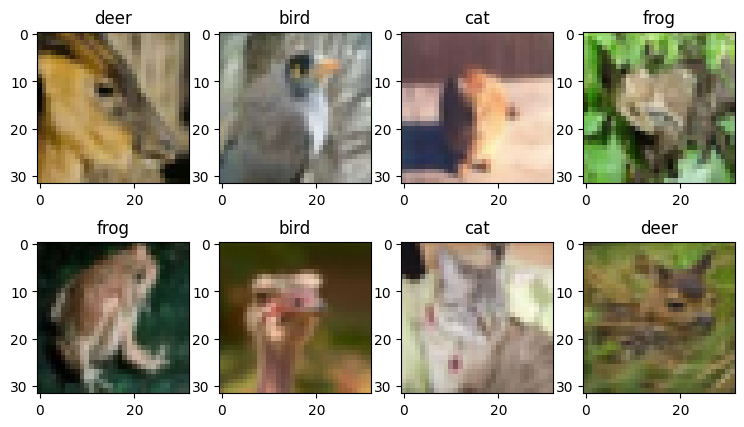

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=0
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=0
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])


Tamanho do conjunto de treino: 45000
Tamanho do conjunto de validação: 5000
Tamanho do conjunto de teste: 10000

--- Starting Hyperparameter Search ---

[1/16] Testing params: {'conv1_hidden_size': 16, 'conv1_kernel_size': 3, 'pool_kernel_size': 2, 'pool_stride': 2, 'conv2_hidden_size': 32, 'linear_output_size': 84}
Epoch 1, Val Loss: 1.8090
Epoch 2, Val Loss: 1.6067
Epoch 3, Val Loss: 1.4587
Epoch 4, Val Loss: 1.3823
Epoch 5, Val Loss: 1.3328
Epoch 6, Val Loss: 1.2900
Epoch 7, Val Loss: 1.2529
Epoch 8, Val Loss: 1.2340
Epoch 9, Val Loss: 1.1942
Epoch 10, Val Loss: 1.1820
Validation Accuracy: 57.66%
*** New best validation accuracy found: 57.66% ***

[2/16] Testing params: {'conv1_hidden_size': 16, 'conv1_kernel_size': 3, 'pool_kernel_size': 2, 'pool_stride': 2, 'conv2_hidden_size': 32, 'linear_output_size': 120}
Epoch 1, Val Loss: 1.8241
Epoch 2, Val Loss: 1.6232
Epoch 3, Val Loss: 1.4552
Epoch 4, Val Loss: 1.3861
Epoch 5, Val Loss: 1.3378
Epoch 6, Val Loss: 1.2785
Epoch 7, Val Loss: 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 1.9399, Val Loss: 1.6894
Validation loss decreased. Saving model.
Epoch 2/50, Train Loss: 1.5674, Val Loss: 1.4768
Validation loss decreased. Saving model.
Epoch 3/50, Train Loss: 1.4057, Val Loss: 1.3739
Validation loss decreased. Saving model.
Epoch 4/50, Train Loss: 1.2993, Val Loss: 1.2907
Validation loss decreased. Saving model.
Epoch 5/50, Train Loss: 1.2295, Val Loss: 1.2375
Validation loss decreased. Saving model.
Epoch 6/50, Train Loss: 1.1624, Val Loss: 1.1773
Validation loss decreased. Saving model.
Epoch 7/50, Train Loss: 1.1067, Val Loss: 1.1431
Validation loss decreased. Saving model.
Epoch 8/50, Train Loss: 1.0649, Val Loss: 1.1004
Validation loss decreased. Saving model.
Epoch 9/50, Train Loss: 1.0151, Val Loss: 1.0682
Validation loss decreased. Saving model.
Epoch 10/50, Train Loss: 0.9783, Val Loss: 1.0327
Validation loss decreased. Saving model.
Epoch 11/50, Train Loss: 0.9503, Val Loss: 1.0006
Validation loss decreased. Saving model.
Epoch 12

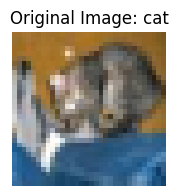

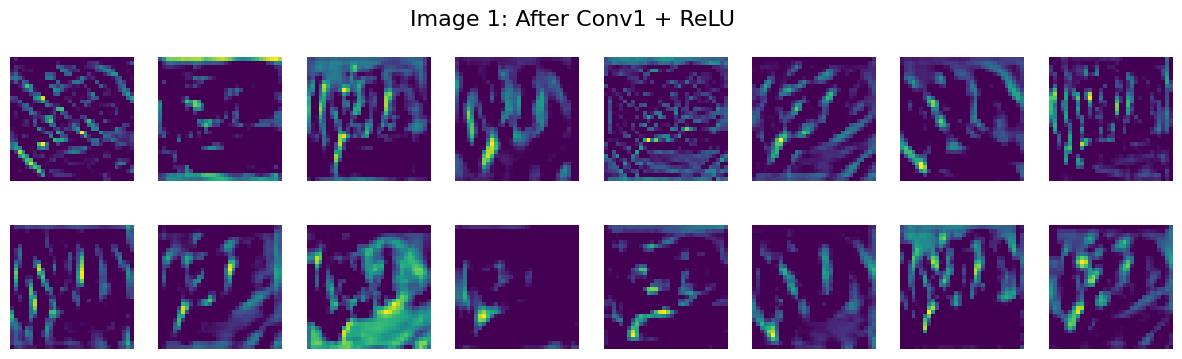

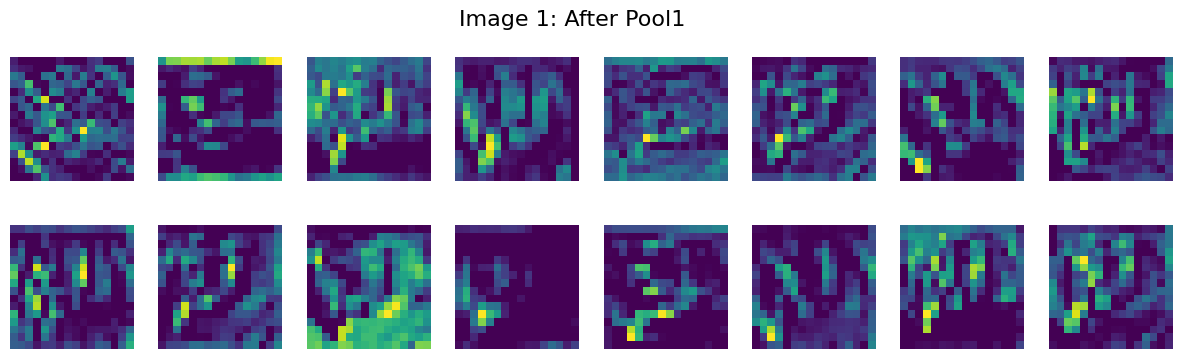

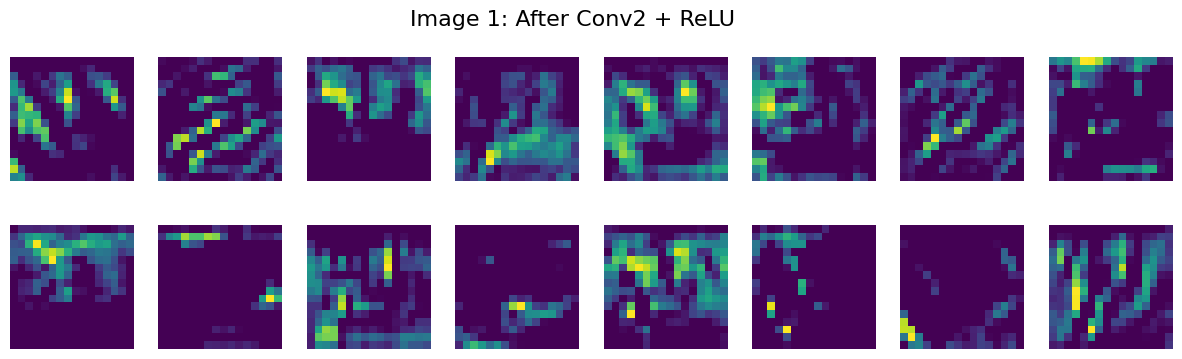

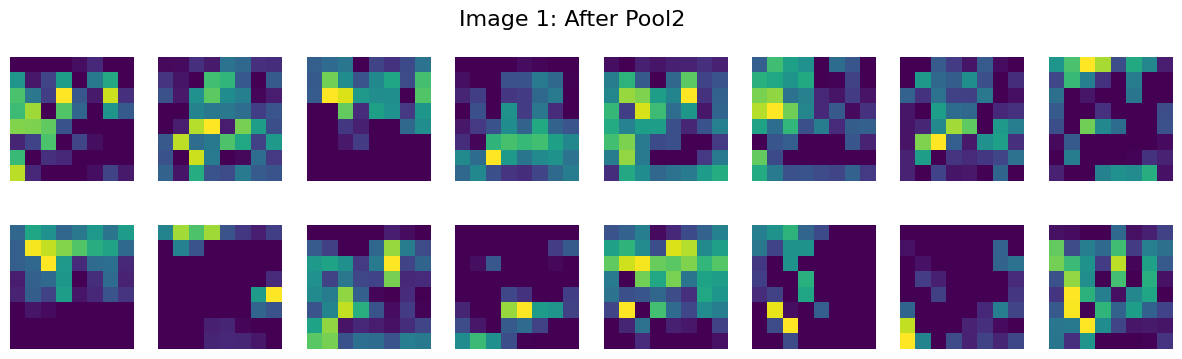


--- Analysis for Image 2 (Class: ship) ---


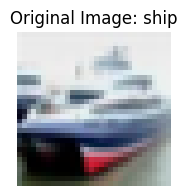

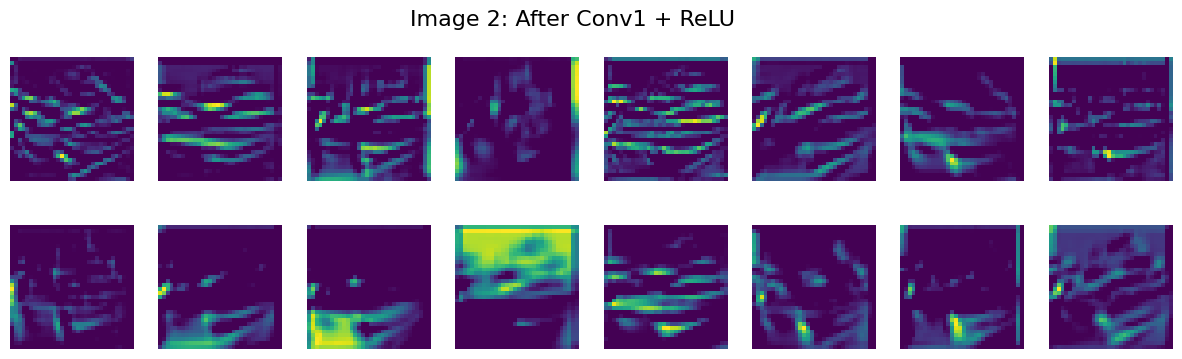

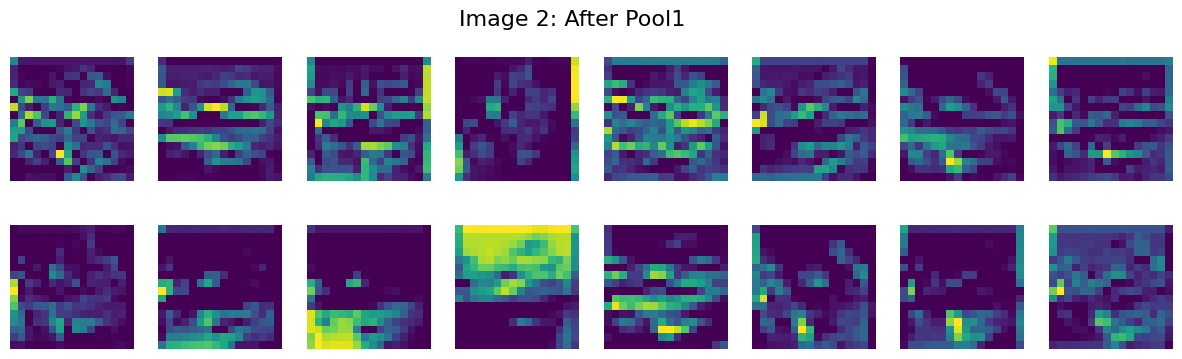

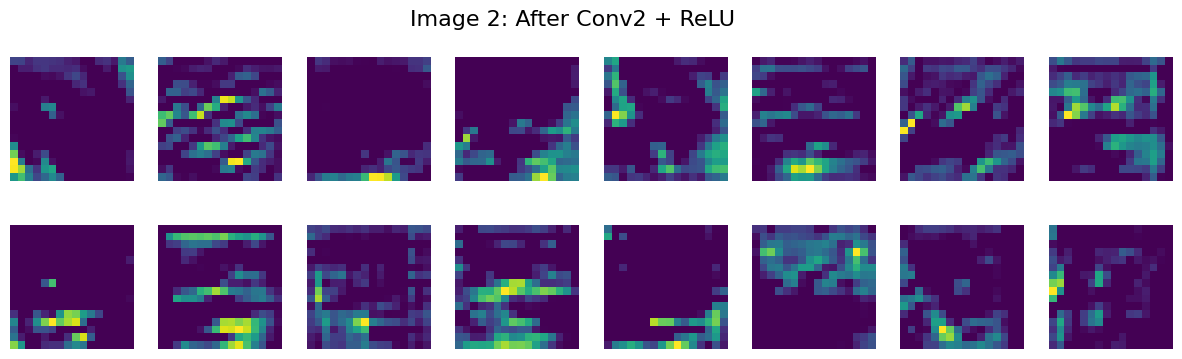

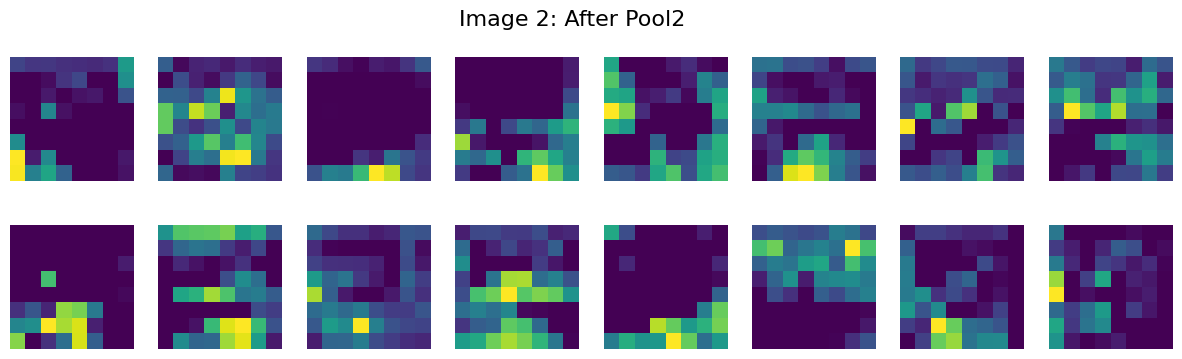

In [ ]:
import itertools

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

print(f"Tamanho do conjunto de treino: {len(train_subset)}")
print(f"Tamanho do conjunto de validação: {len(val_subset)}")
print(f"Tamanho do conjunto de teste: {len(test_set)}")

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)


# --- Hyperparameter Lists ---
conv1_hidden_size_list = [16, 32]
conv1_kernel_size_list = [3, 5]
pool_kernel_size_list = [2]
pool_stride_map = {2: [2]}
conv2_hidden_size_list = [32, 64]
linear_output_size_list = [84, 120]

# --- Model Definition ---
class CNN_2(nn.Module):
    def __init__(self, conv1_hidden_size, conv1_kernel_size, pool_kernel_size, pool_stride, conv2_hidden_size, linear_output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, conv1_hidden_size, conv1_kernel_size, padding=conv1_kernel_size//2)
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride)
        self.conv2 = nn.Conv2d(conv1_hidden_size, conv2_hidden_size, 5, padding=2)
        self.pool2 = nn.MaxPool2d(pool_kernel_size, pool_stride)

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool2(F.relu(self.conv2(x)))
            flattened_size = x.flatten(1).shape[1]

        self.fc1 = nn.Linear(flattened_size, linear_output_size)
        self.fc2 = nn.Linear(linear_output_size, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Hyperparameter Search ---
best_val_accuracy = 0.0
best_params = {}
search_epochs = 10
early_stopping_patience_search = 3

print("\n--- Starting Hyperparameter Search ---")

param_combinations = list(itertools.product(
    conv1_hidden_size_list, conv1_kernel_size_list, pool_kernel_size_list,
    conv2_hidden_size_list, linear_output_size_list
))

for i, params in enumerate(param_combinations):
    conv1_hidden_size, conv1_kernel_size, pool_kernel_size, conv2_hidden_size, linear_output_size = params
    pool_stride = pool_stride_map[pool_kernel_size][0]

    if conv2_hidden_size < conv1_hidden_size:
        continue

    current_params = {
        'conv1_hidden_size': conv1_hidden_size, 'conv1_kernel_size': conv1_kernel_size,
        'pool_kernel_size': pool_kernel_size, 'pool_stride': pool_stride,
        'conv2_hidden_size': conv2_hidden_size, 'linear_output_size': linear_output_size
    }
    print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {current_params}")

    model = CNN_2(**current_params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

    best_epoch_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(search_epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_epoch_val_loss:
            best_epoch_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience_search:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_params = current_params
        print(f"*** New best validation accuracy found: {best_val_accuracy:.2f}% ***")

print("\n--- Hyperparameter Search Finished ---")
print(f"Best parameters found: {best_params}")
print(f"Best validation accuracy during search: {best_val_accuracy:.2f}%")

# --- Train the Best Model ---
print("\n--- Training the Best Model with Early Stopping ---")
best_model = CNN_2(**best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2, verbose=True)
num_epochs_final = 50
early_stopping_patience_final = 5
patience_counter = 0
best_final_val_loss = float('inf')

for epoch in range(num_epochs_final):
    best_model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    best_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_train_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs_final}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_final_val_loss:
        best_final_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model.state_dict(), 'best_model.pth')
        print("Validation loss decreased. Saving model.")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience_final:
        print(f"Final training early stopping triggered after {epoch+1} epochs.")
        break

print('Finished Training.')
best_model.load_state_dict(torch.load('best_model.pth'))

# --- Final Evaluation on TEST Data ---
print("\n--- Final Evaluation on Test Data ---")
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {final_accuracy:.2f}%')

# --- Visualization of Intermediate Layers ---
print("\n--- Visualizing Layer Activations for 2 Test Images ---")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def plot_feature_maps(feature_maps, title):
    feature_maps = feature_maps.detach().cpu()
    fm = feature_maps[0]
    num_to_plot = min(fm.shape[0], 16)
    fig, axes = plt.subplots(2, (num_to_plot + 1) // 2, figsize=(15, 4))
    axes = axes.flatten()
    fig.suptitle(title, fontsize=16)

    for i in range(num_to_plot):
        ax = axes[i]
        ax.imshow(fm[i], cmap='viridis')
        ax.axis('off')

    for i in range(num_to_plot, len(axes)):
        axes[i].axis('off')

    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images_to_show = images[0:2].to(device)

best_model.eval()
with torch.no_grad():
    out_conv1 = F.relu(best_model.conv1(images_to_show))
    out_pool1 = best_model.pool(out_conv1)
    out_conv2 = F.relu(best_model.conv2(out_pool1))
    out_pool2 = best_model.pool(out_conv2)

for i in range(2):
    print(f"\n--- Analysis for Image {i+1} (Class: {classes[labels[i]]}) ---")

    plt.figure(figsize=(2,2))
    imshow(images[i])
    plt.title(f"Original Image: {classes[labels[i]]}")
    plt.show()

    plot_feature_maps(out_conv1[i:i+1], f"Image {i+1}: After Conv1 + ReLU")
    plot_feature_maps(out_pool1[i:i+1], f"Image {i+1}: After Pool1")
    plot_feature_maps(out_conv2[i:i+1], f"Image {i+1}: After Conv2 + ReLU")
    plot_feature_maps(out_pool2[i:i+1], f"Image {i+1}: After Pool2")


### Comentário

Pudemos ver que a busca por hiperparâmetros trouxe resultados realmente interessantes para o modelo. A junção dos dados de treino e validação ao final foi primordial para alcançar um desempenho muito melhor. Isso se deve ao fato de que a CNN possui muitos parâmetros e, portanto, precisa de uma quantidade significativa de dados para evitar overfitting.

Sobre as imagens intermediárias, podemos notar que elas são bem estranhas à primeira vista, mas é visível o processo de abstração acontecendo. Observa-se que o modelo vai reduzindo o nível de detalhes a cada camada, focando em características cada vez mais relevantes para a tarefa.

# Gaussian Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

Text(0.5, 1.0, 'GP posterior')

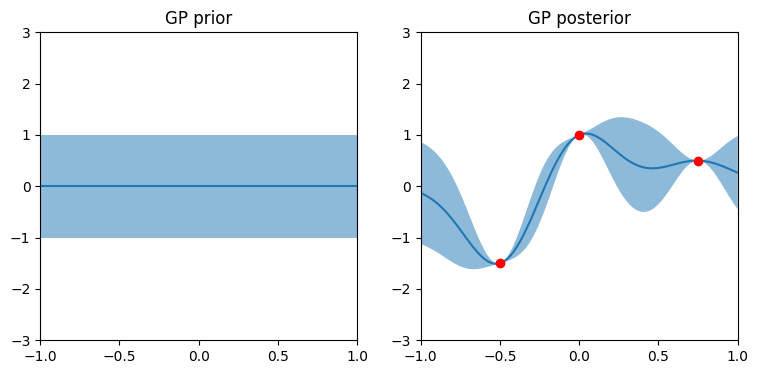

In [36]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0, s2=s2):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)

    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')

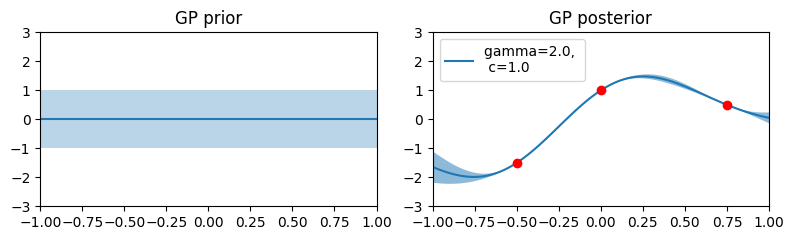

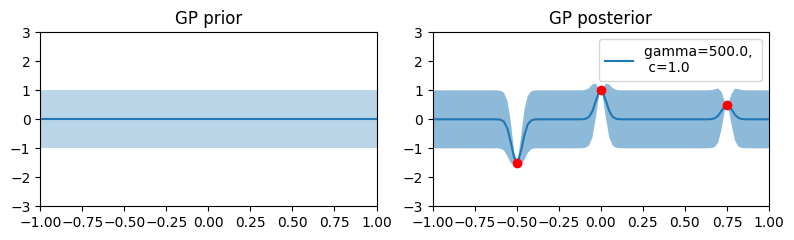

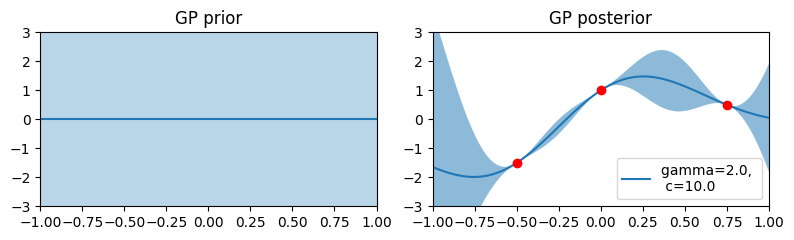

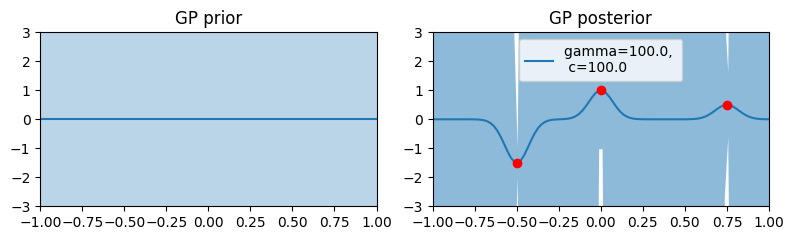

In [10]:
for gamma, c in [(2.0, 1), (500.0, 1), (2.0, 10.0), (100, 100)]:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))

    K = rbf_kernel(x, x, gamma, c) + torch.eye(x.shape[0])*s2
    mu = torch.zeros_like(x)

    axs[0].plot(x, mu)
    axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.3)
    axs[0].set_xlim([-1, 1])
    axs[0].set_ylim([-3, 3])
    axs[0].set_title('GP prior')

    post_mu, post_cov = posterior_pred(x, xtrain, ytrain, gamma, c)
    axs[1].plot(x, post_mu)
    axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
    axs[1].scatter(xtrain, ytrain, color='red', zorder=5, label = 'Dados de treino')
    axs[1].set_xlim([-1, 1])
    axs[1].set_ylim([-3, 3])
    axs[1].set_title('GP posterior')
    axs[1].legend(['gamma={:.1f}, \n c={:.1f}'.format(gamma, c)])

    plt.tight_layout()
    plt.show()

### Comentário:

Quando mudamos o valor de **gamma** na função de kernel, estamos alterando o quanto a curva da predição (média) se ajusta aos dados. Por exemplo, se colocarmos **gamma = 500**, a curva fica praticamente uma reta, que só se movimenta nos pontos de dados para passar por eles — fora isso, ela fica bem “rígida”.

É importante saber que **gamma não muda a distribuição a priori**. Isso fica claro quando olhamos os gráficos 1 e 2: mesmo com **gamma = 2** em um e **gamma = 500** no outro, a distribuição a priori (a curva antes de ver os dados) é a mesma.

Já o parâmetro **c** tem efeito tanto na **priori** quanto na **posteriori**. Ele define a amplitude do desvio padrão, ou seja, o quanto as curvas “sombreadas” variam para cima e para baixo. A priori, o desvio padrão é simplesmente **±c** ao redor da média.

Na posteriori (depois que vemos os dados), o **c** ainda define essa amplitude, mas agora o desvio padrão se ajusta aos dados: ele diminui perto dos pontos observados e aumenta nos espaços entre eles. Por exemplo, se usarmos **gamma = 100** e **c = 100**, a curva continua parecida com a priori, mas com pequenas mudanças perto dos pontos para encaixar os dados.


---

**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [14]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

In [11]:
gamma_division_values = torch.linspace(1, 10, 10)
sigma2_n_division_values = torch.linspace(2, 100, 15)
c = torch.var(torch.tensor(train_y))
best_loss = np.inf

# loss function
def loss(X, y, gamma, c, sigma2_n):
    X = torch.tensor(X)
    y = torch.tensor(y)
    K = rbf_kernel(X, X, gamma, c)
    first = -0.5*torch.logdet(K + (sigma2_n*torch.eye(len(X))))
    second = -0.5*(y.T @ torch.inverse(K + (sigma2_n*torch.eye(len(X)))) @ y)

    return -(first + second) #para minimizar


# train model function
def optimizer(X, y, gamma, c, sigma2_n):
    opt = torch.optim.Adam([gamma, c, sigma2_n], lr=0.001)
    losses = []
    gammas = []
    sigma2_ns = []
    cs = []

    for i in range(200):
        gammas.append(gamma.item())
        sigma2_ns.append(sigma2_n.item())
        cs.append(c.item())
        opt.zero_grad()
        updated_loss = loss(X, y, gamma, c, sigma2_n)
        losses.append(updated_loss.item())

        updated_loss.backward()
        opt.step()

    return losses, gammas, sigma2_ns, cs

c.requires_grad = True

# train model
for gamma_division_value in gamma_division_values:
    for sigma2_n_division_value in sigma2_n_division_values:

        # initialize parameters
        gamma = gamma_division_value/(2 * torch.std(torch.tensor(train_X)))
        gamma.requires_grad = True
        sigma2_n = torch.sqrt(c).detach()/sigma2_n_division_value
        sigma2_n.requires_grad = True

        # apply optimizer
        losses, gammas, sigma2_ns, cs = optimizer(train_X, train_y, gamma, c, sigma2_n)

        print(f'gamma_division_value: {gamma_division_value}, sigma2_n_division_value: {sigma2_n_division_value} - loss {losses[-1]}')
        if losses[-1] < best_loss: #invertemos lá em cima
            best_loss = losses[-1]
            best_loss_vector = losses

            # save best parameters vectors
            best_gammas = gammas
            best_sigma2_ns = sigma2_ns
            best_c = cs

gamma_division_value: 1.0, sigma2_n_division_value: 2.0 - loss -60.51514947174633
gamma_division_value: 1.0, sigma2_n_division_value: 9.0 - loss -61.56109718312116
gamma_division_value: 1.0, sigma2_n_division_value: 16.0 - loss -62.50544607541601
gamma_division_value: 1.0, sigma2_n_division_value: 23.0 - loss -63.27387566068508
gamma_division_value: 1.0, sigma2_n_division_value: 30.0 - loss -63.90324564606419
gamma_division_value: 1.0, sigma2_n_division_value: 37.0 - loss -64.40846176662929
gamma_division_value: 1.0, sigma2_n_division_value: 44.0 - loss -64.8072213975993
gamma_division_value: 1.0, sigma2_n_division_value: 51.0 - loss -65.1184127113227
gamma_division_value: 1.0, sigma2_n_division_value: 58.0 - loss -65.35889551280636
gamma_division_value: 1.0, sigma2_n_division_value: 65.0 - loss -65.54251123947199
gamma_division_value: 1.0, sigma2_n_division_value: 72.0 - loss -65.68025692858276
gamma_division_value: 1.0, sigma2_n_division_value: 79.0 - loss -65.78078327028967
gamma_di

In [12]:
best_loss, best_gammas[-1], best_sigma2_ns[-1], best_c[-1]

(-147.17627492591924,
 10.381698097500035,
 0.010380541912541934,
 0.8327156143955818)

Text(0.5, 1.0, 'GP posterior (test)')

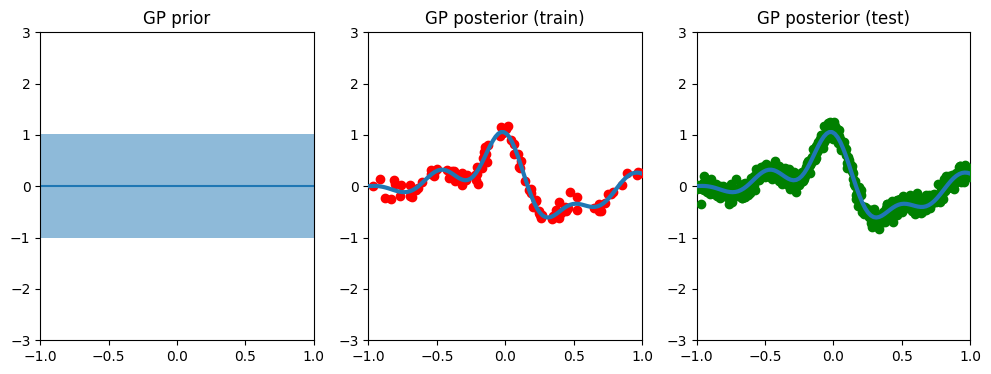

In [16]:
SEED = 42
np.random.seed(SEED)

gamma = best_gammas[-1]
c = best_c[-1]
s2 = best_sigma2_ns[-1]

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)

    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

x = x.to(torch.float32)
xtrain = xtrain.to(torch.float32)
ytrain = ytrain.to(torch.float32)
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)


post_mu, post_cov = posterior_pred(x, train_X, train_y, gamma, c)

axs[1].plot(x, post_mu, zorder=500, linewidth = 3)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(train_X, train_y, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior (train)')

axs[2].plot(x, post_mu, zorder=500, linewidth = 3)
axs[2].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[2].scatter(test_X, test_y, color='green', zorder=5)

axs[2].set_xlim([-1, 1])
axs[2].set_ylim([-3, 3])
axs[2].set_title('GP posterior (test)')


In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

# Certifica que test_X e test_y são tensores float32
test_X = torch.tensor(test_X, dtype=torch.float32)

# Gera predições para os dados de teste
test_mu, test_cov = posterior_pred(test_X, train_X, train_y, gamma, c)

mu_np = test_mu.clone().detach().numpy().squeeze()
y_np = test_y.clone().detach().numpy().squeeze()

# MSE
mse = np.mean((y_np - mu_np) ** 2)
print(f"MSE nos dados de teste: {mse:.4f}\n")
print("-"*80)


MSE nos dados de teste: 0.0103

--------------------------------------------------------------------------------


<ipython-input-42-2015763123>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = torch.tensor(test_X, dtype=torch.float32)
